In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
class Linear_BBB(nn.Module):
    """
        Layer of our BNN.
    """

    def __init__(self, input_features, output_features, prior_var=1.):
        """
            Initialization of our layer : our prior is a normal distribution
            centered in 0 and of variance 20.
        """
        # initialize layers
        super().__init__()
        # set input and output dimensions
        self.input_features = input_features
        self.output_features = output_features

        # initialize mu and rho parameters for the weights of the layer
        self.w_mu = nn.Parameter(torch.zeros(output_features, input_features))
        self.w_rho = nn.Parameter(torch.zeros(output_features, input_features))

        #initialize mu and rho parameters for the layer's bias
        self.b_mu = nn.Parameter(torch.zeros(output_features))
        self.b_rho = nn.Parameter(torch.zeros(output_features))

        #initialize weight samples (these will be calculated whenever the layer makes a prediction)
        self.w = None
        self.b = None

        # initialize prior distribution for all of the weights and biases
        self.prior = torch.distributions.Normal(0, prior_var)

    def forward(self, input):
        """
          Optimization process
        """
        # sample weights
        w_epsilon = Normal(0, 1).sample(self.w_mu.shape)
        self.w = self.w_mu + torch.log(1 + torch.exp(self.w_rho)) * w_epsilon

        # sample bias
        b_epsilon = Normal(0, 1).sample(self.b_mu.shape)
        self.b = self.b_mu + torch.log(1 + torch.exp(self.b_rho)) * b_epsilon

        # record log prior by evaluating log pdf of prior at sampled weight and bias
        w_log_prior = self.prior.log_prob(self.w)
        b_log_prior = self.prior.log_prob(self.b)
        self.log_prior = torch.sum(w_log_prior) + torch.sum(b_log_prior)

        # record log variational posterior by evaluating log pdf of normal distribution defined by parameters with respect at the sampled values
        self.w_post = Normal(self.w_mu.data, torch.log(1 + torch.exp(self.w_rho)))
        self.b_post = Normal(self.b_mu.data, torch.log(1 + torch.exp(self.b_rho)))
        self.log_post = self.w_post.log_prob(self.w).sum() + self.b_post.log_prob(self.b).sum()

        return F.linear(input, self.w, self.b)

In [3]:



class MLP_BBB(nn.Module):
    def __init__(self, hidden_units, noise_tol=.1, prior_var=1.):
        # initialize the network like you would with a standard multilayer perceptron, but using the BBB layer
        super().__init__()
        self.hidden = Linear_BBB(1, hidden_units, prior_var=prior_var)
        self.out = Linear_BBB(hidden_units, 1, prior_var=prior_var)
        self.noise_tol = noise_tol  # we will use the noise tolerance to calculate our likelihood

    def forward(self, x):
        # again, this is equivalent to a standard multilayer perceptron
        x = torch.sigmoid(self.hidden(x))
        x = self.out(x)
        return x

    def log_prior(self):
        # calculate the log prior over all the layers
        return self.hidden.log_prior + self.out.log_prior

    def log_post(self):
        # calculate the log posterior over all the layers
        return self.hidden.log_post + self.out.log_post

    def sample_elbo(self, input, target, samples):
        # we calculate the negative elbo, which will be our loss function
        #initialize tensors
        outputs = torch.zeros(samples, target.shape[0])
        log_priors = torch.zeros(samples)
        log_posts = torch.zeros(samples)
        log_likes = torch.zeros(samples)
        # make predictions and calculate prior, posterior, and likelihood for a given number of samples
        for i in range(samples):
            outputs[i] = self(input).reshape(-1)  # make predictions
            log_priors[i] = self.log_prior()  # get log prior
            log_posts[i] = self.log_post()  # get log variational posterior
            log_likes[i] = Normal(outputs[i], self.noise_tol).log_prob(
                target.reshape(-1)).sum()  # calculate the log likelihood
        # calculate monte carlo estimate of prior posterior and likelihood
        log_prior = log_priors.mean()
        log_post = log_posts.mean()
        log_like = log_likes.mean()
        # calculate the negative elbo (which is our loss function)
        loss = log_post - log_prior - log_like
        return loss


In [4]:
class MC_model(nn.Module):
    def __init__(self,hidden_units):
        super().__init__()
        self.hidden=nn.Linear(1,hidden_units)
        self.hidden2=nn.Linear(hidden_units,16)
        self.out=nn.Linear(16,1)
    def forward(self,x):
        x=torch.relu(self.hidden(x))
        x=torch.relu(self.hidden2(x))
        x=self.out(x)
        return x

In [5]:

def toy_function(x):
    return 2*x + 1


# toy dataset we can start with
x = torch.linspace(-5, 5, 100).reshape(-1, 1)
y = toy_function(x)


In [13]:
net=MC_model(32)
import time

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-3)
epochs = 3000

In [15]:

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs=net(x)
    loss=loss_fn(outputs,y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print('epoch: {}/{}'.format(epoch + 1, epochs))
        print('Loss:', loss.item())
print('Finished Training')


epoch: 1/3000
Loss: -0.0
epoch: 11/3000
Loss: -0.0
epoch: 21/3000
Loss: -0.0
epoch: 31/3000
Loss: -0.0
epoch: 41/3000
Loss: -0.0
epoch: 51/3000
Loss: -0.0
epoch: 61/3000
Loss: -0.0
epoch: 71/3000
Loss: -0.0
epoch: 81/3000
Loss: -0.0
epoch: 91/3000
Loss: -0.0
epoch: 101/3000
Loss: -0.0
epoch: 111/3000
Loss: -0.0
epoch: 121/3000
Loss: -0.0
epoch: 131/3000
Loss: -0.0
epoch: 141/3000
Loss: -0.0
epoch: 151/3000
Loss: -0.0
epoch: 161/3000
Loss: -0.0
epoch: 171/3000
Loss: -0.0
epoch: 181/3000
Loss: -0.0
epoch: 191/3000
Loss: -0.0
epoch: 201/3000
Loss: -0.0
epoch: 211/3000
Loss: -0.0
epoch: 221/3000
Loss: -0.0
epoch: 231/3000
Loss: -0.0
epoch: 241/3000
Loss: -0.0
epoch: 251/3000
Loss: -0.0
epoch: 261/3000
Loss: -0.0
epoch: 271/3000
Loss: -0.0
epoch: 281/3000
Loss: -0.0
epoch: 291/3000
Loss: -0.0
epoch: 301/3000
Loss: -0.0
epoch: 311/3000
Loss: -0.0
epoch: 321/3000
Loss: -0.0
epoch: 331/3000
Loss: -0.0
epoch: 341/3000
Loss: -0.0
epoch: 351/3000
Loss: -0.0
epoch: 361/3000
Loss: -0.0
epoch: 371/3

In [16]:
net(torch.tensor([1.0]))

tensor([-0.1035], grad_fn=<AddBackward0>)

In [17]:
net = MLP_BBB(32, prior_var=10)
oprimizer = optim.Adam(net.parameters(), lr=.1)
epochs = 3000
for epoch in range(epochs):
    oprimizer.zero_grad()
    loss = net.sample_elbo(x, y, 1)
    loss.backward()
    oprimizer.step()
    if epoch % 10 == 0:
        print('epoch: {}/{}'.format(epoch + 1, epochs))
        print('Loss:', loss.item())
print('Finished Training')


epoch: 1/3000
Loss: 15015779.0
epoch: 11/3000
Loss: 13574210.0
epoch: 21/3000
Loss: 12383037.0
epoch: 31/3000
Loss: 10863500.0
epoch: 41/3000
Loss: 9690331.0
epoch: 51/3000
Loss: 8909175.0
epoch: 61/3000
Loss: 8162020.0
epoch: 71/3000
Loss: 7780830.5
epoch: 81/3000
Loss: 7486295.5
epoch: 91/3000
Loss: 7261679.5
epoch: 101/3000
Loss: 6927412.5
epoch: 111/3000
Loss: 6718884.5
epoch: 121/3000
Loss: 5964948.0
epoch: 131/3000
Loss: 5505934.0
epoch: 141/3000
Loss: 4948380.5
epoch: 151/3000
Loss: 4584487.5
epoch: 161/3000
Loss: 4294805.5
epoch: 171/3000
Loss: 4048681.5
epoch: 181/3000
Loss: 3511758.0
epoch: 191/3000
Loss: 3473750.75
epoch: 201/3000
Loss: 3134670.0
epoch: 211/3000
Loss: 3095911.0
epoch: 221/3000
Loss: 2849949.75
epoch: 231/3000
Loss: 2568581.75
epoch: 241/3000
Loss: 2442790.0
epoch: 251/3000
Loss: 2455814.75
epoch: 261/3000
Loss: 2121606.75
epoch: 271/3000
Loss: 2039653.125
epoch: 281/3000
Loss: 1976616.5
epoch: 291/3000
Loss: 1915227.75
epoch: 301/3000
Loss: 1800552.125
epoch

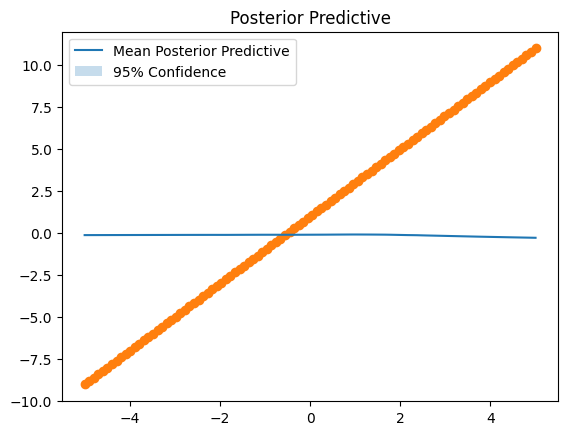

torch.Size([100, 1])

In [36]:
# samples is the number of "predictions" we make for 1 x-value.
samples = 100
x_tmp = torch.linspace(-5, 5, 100).reshape(-1, 1)
y_samp = np.zeros((samples, 100))
for s in range(samples):
    y_tmp = net(x_tmp).detach().numpy()
    y_samp[s] = y_tmp.reshape(-1)
plt.plot(x_tmp.numpy(), np.mean(y_samp, axis=0), label='Mean Posterior Predictive')
plt.fill_between(x_tmp.numpy().reshape(-1), np.percentile(y_samp, 2.5, axis=0), np.percentile(y_samp, 97.5, axis=0),
                 alpha=0.25, label='95% Confidence')
plt.legend()
plt.scatter(x, toy_function(x))
plt.title('Posterior Predictive')

plt.show()
x_tmp.shape

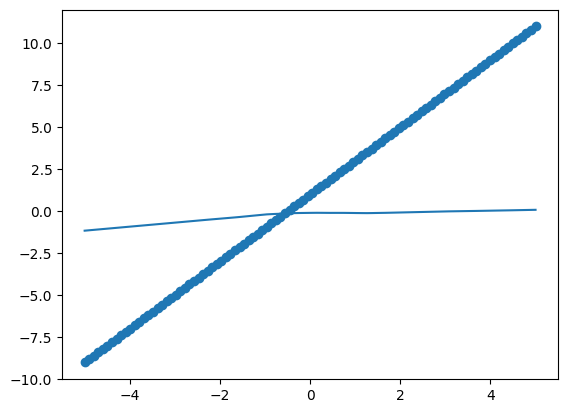

In [17]:
x_tmp = torch.linspace(-5, 5, 100).reshape(-1, 1)
plt.plot(x_tmp.numpy(), net(x_tmp).detach().numpy(), label='Mean Posterior Predictive')
plt.scatter(x, toy_function(x))